In [1]:
import pandas as pd

In [98]:
"""
    Load Data
"""
# Read ais_train.csv
ais_train = pd.read_csv("ais_train.csv", sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time'])

# We assume that speed is lees than 25 knots is appropriate
ais_train = ais_train[(ais_train['sog'] < 25)]
ais_train['navstat'] = ais_train['navstat'].replace(8, 0) # every boat that is under sail is under way
ais_train = ais_train[~((ais_train['navstat'].isin([1, 5])) & (ais_train['sog'] > 0))] # standing still, should have 0 speed
ais_train = ais_train[~((ais_train['navstat'].isin([2])) & (ais_train['sog'] > 5))]



vessels = pd.read_csv("vessels.csv", sep='|')[['shippingLineId', 'vesselId']]
ais_train_merged = pd.merge(ais_train, vessels, on='vesselId', how='left')

ports = pd.read_csv("ports.csv", sep='|')[['portId', 'longitude', 'latitude']]
ports = ports.rename(columns={'longitude': 'portLongitude', 'latitude': 'portLatitude'})
ais_train_merged = pd.merge(ais_train, ports, on='portId', how='right')

navstat_mapping = {
    0: 'Under way using engine',
    1: 'At anchor',
    2: 'Not under command',
    3: 'Restricted manoeuverability',
    4: 'Constrained by her draught',
    5: 'Moored',
    6: 'Aground',
    7: 'Engaged in Fishing',
    8: 'Under way sailing',
    9: 'Reserved for future amendment of Navigational Status for HSC',
    10: 'Reserved for future amendment of Navigational Status for WIG',
    11: 'Reserved for future use',
    12: 'Reserved for future use',
    13: 'Reserved for future use',
    14: 'AIS-SART is active',
    15: 'Not defined (default)'
}

# Apply the mapping to the 'navstat' column in the ais_train DataFrame
ais_train['navstat_description'] = ais_train['navstat'].map(navstat_mapping)

# Display the first few rows to confirm the mapping
ais_train

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,navstat_description
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,Under way using engine
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689,At anchor
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19,Under way using engine
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126,At anchor
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3,Under way using engine
...,...,...,...,...,...,...,...,...,...,...,...,...
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417,Under way using engine
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1,Under way using engine
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b,Under way using engine
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b,Under way using engine


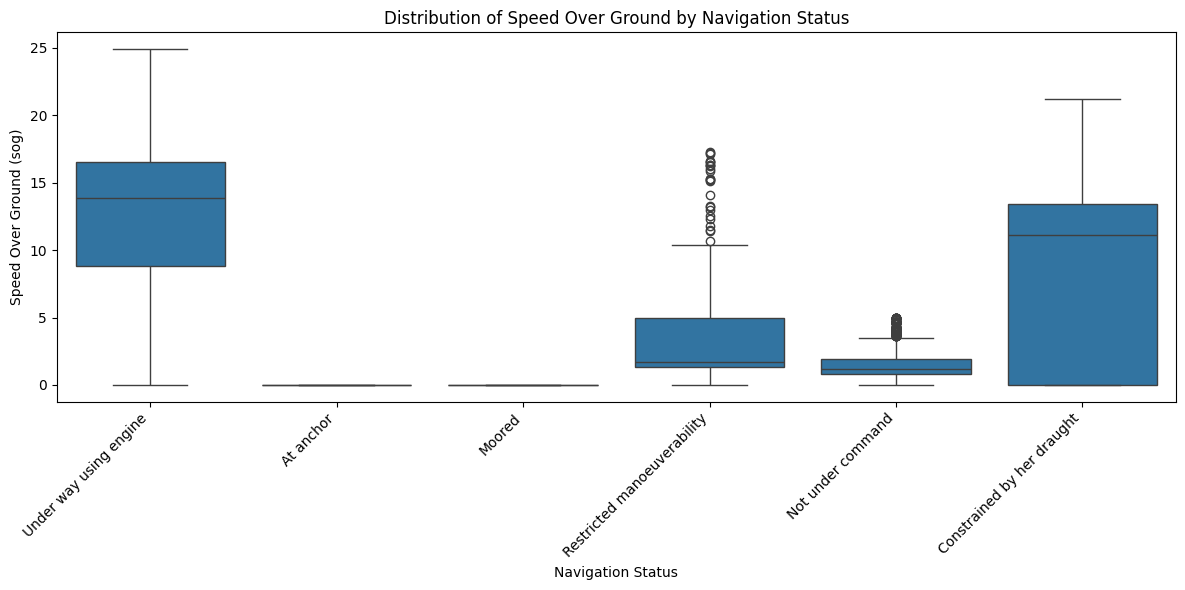

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map the numeric navstat values to their descriptive names
ais_train['navstat_description'] = ais_train['navstat'].map(navstat_mapping)

# Filter data to include only the navstat descriptions we're interested in (e.g., navstat < 6)
filtered_data = ais_train[ais_train['navstat'] < 6]

# Create a box plot to visualize the distribution of sog for each navstat description
plt.figure(figsize=(12, 6))
sns.boxplot(x='navstat_description', y='sog', data=filtered_data)
plt.xlabel('Navigation Status')
plt.ylabel('Speed Over Ground (sog)')
plt.title('Distribution of Speed Over Ground by Navigation Status')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [101]:
from scipy.stats import kruskal

# Create groups of SOG values for each navstat_description
groups = [filtered_data[filtered_data['navstat_description'] == description]['sog'] for description in filtered_data['navstat_description'].unique()]

# Perform the Kruskal-Wallis H-test
stat, p_value = kruskal(*groups)

print(f'Kruskal-Wallis H-test statistic: {stat}, p-value: {p_value}')

Kruskal-Wallis H-test statistic: 1077206.2292582435, p-value: 0.0
